In [187]:
#! usr/bin/env python3

import cv2
import pytesseract
from matplotlib import pyplot as plt
import re
import numpy as np

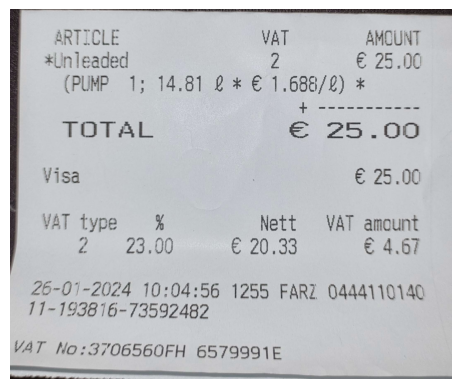

In [188]:
image_path = 'Reciepts/test2.jpg'
image = cv2.imread(image_path)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

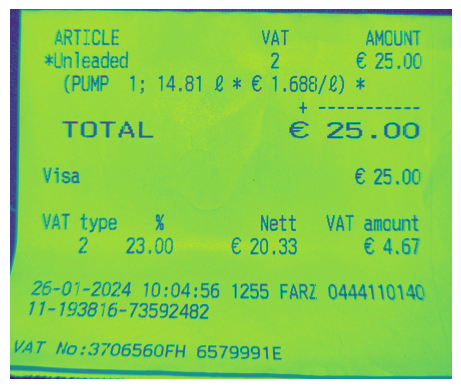

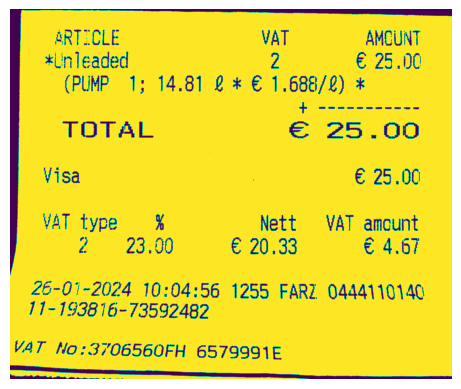

In [189]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()

In [190]:
text = pytesseract.image_to_string(image)
filtered_text = '\n'.join(
    line for line in text.split('\n') if line.strip() != '')

print(filtered_text)

ART CLE VAT AMCUNT
+ _nleaded 2 € 25.0C
(PUMP 1: 14.81 2 * € 1.688/2) *
+ ee ee eee ee
TOTAL e& 75.00
Visa | € 25.00
VAT type A Nett VAT amount
Z 23.00 E 20.33 € 4.67
25-01-2024 10:04:56 1255 FARZ 0444110140
11-1938 16-73592482
V4T No:3706560FH 6579991E


In [191]:
import re
from fuzzywuzzy import process

def extract_receipt_info_single(receipt_text):
    # Convert all text to lowercase to simplify matching
    text_lower = receipt_text.lower()

    # Initialize the result dictionary
    info = {
        'fuel_type': None,
        'volume': None,
        'price_per_litre': None,
        'total': None
    }

    # https://stackoverflow.com/questions/1547574/regex-for-prices
    volume_pattern = r"(?i)(?:volume|;|:|diesel|unleaded)\s*(\d+(?:[.,]\d{2}))\s*°?\s*(ltr|l)?"
    price_per_litre_pattern = r"(?:price|€)\s*([1-9][.,]\d{3})\s*(eur/l|/l|/)?\s*"

    total_pattern = r"(?:total €|total|€)\s*(\d+\.\d+)?\s*"

    # Define fuel type choices for fuzzy matching
    fuel_type_choices = ["unleaded", "diesel"]

    # Search for fuel type with fuzzy match
    fuel_type_match = process.extractOne(text_lower, fuel_type_choices, score_cutoff=50)
    if fuel_type_match:
        info['fuel_type'] = fuel_type_match[0]

    # Search for volume
    volume_match = re.search(volume_pattern, text_lower)
    if volume_match:
        info['volume'] = next((m for m in volume_match.groups() if m), None)

    # Search for price per litre
    price_per_litre_match = re.search(price_per_litre_pattern, text_lower)
    if price_per_litre_match:
        info['price_per_litre'] = next((m for m in price_per_litre_match.groups() if m), None)

    # Search for total
    total_match = re.search(total_pattern, text_lower)
    if total_match:
        info['total'] = total_match.group(1)

    return info

# Example usage
extracted_info_single = extract_receipt_info_single(filtered_text)
print(extracted_info_single)


{'fuel_type': 'unleaded', 'volume': '14.81', 'price_per_litre': '1.688', 'total': '25.0'}


I have an ocr'd image of a fuel reciept, from the extracted text which is now called filtered_text in the python script.

I want to find the following 4: fuel_type (Diesel or Unleaded), volume, price_per_litre, and total.

Throughout the various reciept i have in my set i noticed a pattern in which all required details appear after the pump used. Example "Pump 8".

fuel type is mentioned within the reciept with unleaded or diesel. The OCR has trouble getting all the letters so I want to get the fuel type based on whether it is exactly the same, or relatively close in which most letters are very similar to one of the two fuel types

On some reciepts the volume inserted into the vehicle is found after the keyword Volume or volume. The float is followed either by LTR, ltr or has nothing.

Price per litre is found on some reciepts after the keyword price and is often accompanied with a '/'. Its is a 4 digit number in which it is always in the same format where the first number is a whole number and the remainder is a decimal. Example '1.658'. It can be found also by having the word eur/l after the digits

Total in often written in lower case or upper case, it is a float.

I want to identify each of those values from my extracted text. Prefably it would be ideal to make all text lowercase.